In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import os

%matplotlib inline

# Abstract

Seemingly whimsical, the title of this project encloses the harsh reality of how astoundingly primitive we are in the 21st century and how little has actually changed since Medieval times. We attempt to modernise our society in many aspects, invent new technology to make everyday life more pleasant, but at the end of the day, we witness so much violence, intolerance and hatred. Independent of the fact whether it is an inter-country conflict for territory, an organisation requesting rights, a state or region fighting for independence, the truth is these clashes result in numerous casualties, direct or collateral, ruined societies, destroyed lives and terrible loss. And there are much more sparkles on the edge of kindling a fire.

The goal of this project is to make an attempt at uncovering the shocking reality about world conflicts that few people know about because it may not be or have been in the spotlight. Hopefully, observing the aggregated information visualised in a nicely presentable way will help raise awareness of what has been happening in recent history or at the present moment, and bring incentive to start building an improved version of the World.

## Loading and familiarising with the data

In [41]:
DATA_PATH = './data/'

# Primary datasets of interest
ucdp_ged_global_file = os.path.join(DATA_PATH + 'ged171.csv')
ucdp_armed_conflicts_file = os.path.join(DATA_PATH + 'ucdp-prio-acd-171.csv')
ucdp_dyadic_file = os.path.join(DATA_PATH + 'ucdp-dyadic-171.csv')
ucdp_one_sided_violence_file = os.path.join(DATA_PATH + 'ucdp-onesided-171.csv')
ucdp_battle_deaths_file = os.path.join(DATA_PATH + 'ucdp-brd-conf-171.csv')

# Enrichment datasets

# Metadata datasets
ucdp_actor_list_file = os.path.join(DATA_PATH + 'actorlist.csv')

#### UCDP Georeferenced Event Dataset (GED) Global version 17.1 (2016)

This dataset is UCDP's most disaggregated dataset, covering individual events of organized violence (phenomena of lethal violence occurring at a given time and place). These events are sufficiently fine-grained to be geo-coded down to the level of individual villages, with temporal durations disaggregated to single, individudal days.


<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>year</td>
        <td>int</td>
        <td>The year of the event</td>
    </tr>
    <tr>
        <td>active_year</td>
        <td>int</td>
        <td>If the event belongs to an active conflict/dyad/actor-year or otherwise</td>
    </tr>
    <tr>
        <td>conflict_name</td>
        <td>string</td>
        <td>Name of the UCDP conflict to which the event belongs. For non-state conflicts and one-sided violence this is the same as the dyad name</td>
    </tr>
    <tr>
        <td>dyad_new_id</td>
        <td>int</td>
        <td>A unique conflict identification code for each individual dyad in the dataset.</td>
    </tr>
    <tr>
        <td>dyad_name</td>
        <td>string</td>
        <td>Name of the conflict dyad creating the event.
A <b>dyad is the pair of two actors engaged in violence</b> (in the case of one-sided violence, the perpetrator of violence and civilians).
The two sides are separated by an ASCII dash (e.g. Government of Russia - Caucasus Emirate, Taleban - civilians).</td>
    </tr>
    <tr>
        <td>where_prec</td>
        <td>int</td>
        <td>The precision with which the coordinates and location assigned to the event reflects the location of the actual event</td>
    </tr>
</table>

<b>2. Terminology and definitions</b>

The basic unit of analysis for the UCDP GED dataset is the “event”, i.e. an individual incident (phenomenon) of lethal violence occurring at a given time and place. The dataset covers the entire World (except Syria) between 01.01.1989 and 31.12.2016.

  * Event = <i>An incident where armed force was by an <b>organised actor</b> against <b>another organized actor, or against civilians, resulting in at least 1 direct death</b> at a <b>specific location</b> and a <b>specific date</b></i>


In [35]:
# Map certain column values into more meaningful categories
active_year_map = {
    1: 'active',
    0: 'non-active'
}

type_of_violence_map = {
    1: 'state-based',  # government vs. formally organised group
    2: 'non-state',  # formally organised group vs. formally organised group OR informally organised group vs. formally organised group
    3: 'one-sided'  # formally organised group vs. civilians
}

where_prec_map = {
    1: 'exact',
    2: '25km radius',
    3: 'second order administrative division',  # district, municipality or commune
    4: 'first order administrative division',  # province, state or governorate
    5: 'linear region',
    6: 'country',
    7: 'international waters'
}

ged_global_columns = ['year', 'active_year', 'type_of_violence', 
                      'conflict_new_id', 'conflict_name', 'dyad_new_id', 'dyad_name',
                      'side_a_new_id', 'side_b_new_id', 'where_prec', 'where_coordinates',
                      'adm_1', 'adm_2', 'latitude', 'longitude', 'country', 'region',
                      'date_start', 'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
                      'deaths_unknown', 'best', 'low', 'high'
                     ]

In [39]:
ged_global_raw = pd.read_csv(ucdp_ged_global_file, sep=',', header=0, index_col='id')
ged_global_raw.replace({
    'active_year': active_year_map,
    'type_of_violence': type_of_violence_map,
    'where_prec': where_prec_map
}, inplace=True)

ged_global_raw = ged_global_raw[ged_global_columns]
ged_global_raw.head(10)

year active_year type_of_violence  conflict_new_id  \
id                                                       
4   2010      active      state-based              230   
5   2011      active        one-sided              715   
6   2011      active      state-based              230   
7   2012      active      state-based              230   
10  2012      active      state-based              230   
13  2011      active      state-based              230   
14  1994      active      state-based              402   
16  1994      active      state-based              402   
18  1994      active      state-based              402   
19  2010      active      state-based              230   

                                    conflict_name  dyad_new_id  \
id                                                               
4                  Yemen (North Yemen):Government          459   
5   Government of Yemen (North Yemen) - Civilians         1182   
6                  Yemen (North Yemen):Government          459   
7                  Yemen (North Yemen):Government          459   
10                 Yemen (North Yemen):Government          459   
13                 Yemen (North Yemen):Government          459   
14                Yemen (North Yemen):South Yemen          853   
16                Yemen (North Yemen):South Yemen          853   
18                Yemen (North Yemen):South Yemen          853   
19                 Yemen (North Yemen):Government          459   

                                            dyad_name  side_a_new_id  \
id                                                                     
4            Government of Yemen (North Yemen) - AQAP            123   
5       Government of Yemen (North Yemen) - Civilians            123   
6            Government of Yemen (North Yemen) - AQAP            123   
7            Government of Yemen (North Yemen) - AQAP            123   
10           Government of Yemen (North Yemen) - AQAP            123   
13           Government of Yemen (North Yemen) - AQAP            123   
14  Government of Yemen (North Yemen) - Democratic...            123   
16  Government of Yemen (North Yemen) - Democratic...            123   
18  Government of Yemen (North Yemen) - Democratic...            123   
19           Government of Yemen (North Yemen) - AQAP            123   

    side_b_new_id                           where_prec  ...        region  \
id                                                      ...                 
4             881                                exact  ...   Middle East   
5               1                          25km radius  ...   Middle East   
6             881  first order administrative division  ...   Middle East   
7             881  first order administrative division  ...   Middle East   
10            881                                exact  ...   Middle East   
13            881  first order administrative division  ...   Middle East   
14            353  first order administrative division  ...   Middle East   
16            353  first order administrative division  ...   Middle East   
18            353  first order administrative division  ...   Middle East   
19            881  first order administrative division  ...   Middle East   

    date_start    date_end  deaths_a  deaths_b deaths_civilians  \
id                                                                
4   2010-09-25  2010-09-25         2         0                0   
5   2011-02-19  2011-02-19         0         0                0   
6   2011-04-16  2011-04-16         0         0                0   
7   2012-06-04  2012-06-04         4         1                0   
10  2012-12-09  2012-12-09         0         4                1   
13  2011-04-11  2011-04-11         0         0                0   
14  1994-06-08  1994-06-08         0         0                0   
16  1994-02-21  1994-02-24         0         0                0   
18  1994-05-09  1994-05-09         0         0        

In [40]:
ged_global_raw.shape

(135181, 26)

#### UCDP Actor List

A simple list of all the actors (including their full names and alternate names) as available in UCDP datasets version 17.1. No full Actor Dataset has been produced for version 17.1 at this time.

In [17]:
actor_list_raw = pd.read_csv(ucdp_actor_list_file, sep=',', header=0, index_col='ActorID')
actor_list_raw.head(10)

Name  \
ActorID                                           
1                                     Civilians   
2                       Government of Hyderabad   
3        Government of United States of America   
5                            Government of Cuba   
6                           Government of Haiti   
7              Government of Dominican Republic   
8             Government of Trinidad and Tobago   
9                         Government of Grenada   
10                         Government of Mexico   
11                      Government of Guatemala   

                                       NameFull  
ActorID                                          
1                                     Civilians  
2                       Government of Hyderabad  
3        Government of United States of America  
5                            Government of Cuba  
6                           Government of Haiti  
7              Government of Dominican Republic  
8             Government of Trinidad and Tobago  
9                         Government of Grenada  
10                         Government of Mexico  
11                      Government of Guatemala

In [20]:
actor_list_raw.loc[881]

Name                                     AQAP
NameFull    al-Qaida in the Arabian Peninsula
Name: 881, dtype: object

#### UCDP/PRIO Armed Conflict Dataset version 17.1

A conflict-year dataset with information on armed conflict where at least one party is the government of a state in the time period 1946-2016.

The main unit in this dataset is an “Armed Conflict” as defined by UCDP. Each conflict is listed in the database and given a unique ID code. The definition of armed conflict is given in the Terminology and definitions section below.

The observation (or unit) in the Main Conflict table is the conflict-year. Each conflict is listed in all years where fighting in one or more dyad(s) caused at least 25 battle-related deaths.

<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>conflictid</td>
        <td>int</td>
        <td>Two conflict episodes over the same incompatibility will be assigned the same ID regardless of the time separating them. This means a conflict may span over multiple rows in the dataset.</td>
    </tr>
    <tr>
        <td>region</td>
        <td>string</td>
        <td>Region of Location</td>
    </tr>
</table>

<b>2. Terminology and definitions</b>

  * Armed conflict = <i>a contested incompatibility that concerns government and/or territory where the use of armed force between two parties, of which at least one is the government of a state, results in <b>at least 25 battle-related deaths</b> in one calendar year. “Armed conflict” is also referred to as “state-based conflict”, as opposed to “non-state conflict”, in which none of the warring parties is a government.</i>


In [96]:
# Map certain column values into more meaningful categories
incomp_map = {
    1: 'territory',
    2: 'government',
    3: 'government and territory'
}

intensity_map = {
    1: 'minor',  # between 25 and 999 battle-related deaths in a given year
    2: 'war'  # at least 1'000 battle-related deaths in a given year
}

cumint_map = {
    0: 'minor',  # between 25 and 999 battle-related deaths for the entire conflict period
    1: 'war'  # more than 1'000 battle-related deaths for the entire conflict period
}

type_map = {
    1: 'extrasystemic',  # between a state and a non-state group outside its own territory
    2: 'interstate',  # between two or more states
    3: 'internal',  # between the government of a state and one or more internal opposition group(s) without intervention from other states
    4: 'internationalized'  # between the government of a state and one or more internal opposition group(s) with intervention from other states on one or both sides
}

region_map = {
    '1': 'Europe',
    '2': 'Middle East',
    '3': 'Asia',
    '4': 'Africa',
    '5': 'Americas'
}

armed_conflicts_columns = ['conflictid', 'location', 'sidea', 'side b' , 'sidebid',
                      'incomp', 'year', 'intensity', 'cumint', 'type',
                      'startdate', 'startdate2', 'ependdate', 'region'
                     ]

In [114]:
armed_conflicts_raw = pd.read_csv(ucdp_armed_conflicts_file, sep=',', header=0)
armed_conflicts_raw.replace({
    'incomp': incomp_map,
    'intensity': intensity_map,
    'cumint': cumint_map,
    'type': type_map,
    'region': region_map
}, inplace=True)

# Handle the case where there are multiple regions in the same cell
for key in region_map.keys():
    armed_conflicts_raw['region'] = armed_conflicts_raw['region'].str.replace(r'(%s,?)' % (key), '%s,' % (region_map[key]))
armed_conflicts_raw['region'] = armed_conflicts_raw['region'].str.rstrip(',')

armed_conflicts_raw = armed_conflicts_raw[armed_conflicts_columns]
armed_conflicts_raw.shape

(2277, 14)

In [115]:
armed_conflicts_raw.head(10)

conflictid              location                  sidea  \
0         200               Bolivia  Government of Bolivia   
1         200               Bolivia  Government of Bolivia   
2         200               Bolivia  Government of Bolivia   
3         201  Cambodia (Kampuchea)   Government of France   
4         201  Cambodia (Kampuchea)   Government of France   
5         201  Cambodia (Kampuchea)   Government of France   
6         201  Cambodia (Kampuchea)   Government of France   
7         201  Cambodia (Kampuchea)   Government of France   
8         201  Cambodia (Kampuchea)   Government of France   
9         201  Cambodia (Kampuchea)   Government of France   

                           side b sidebid      incomp  year intensity cumint  \
0  Popular Revolutionary Movement     719  government  1946       war    war   
1                             MNR     720  government  1952     minor    war   
2                             ELN     721  government  1967     minor    war   
3                   Khmer Issarak     160   territory  1946     minor  minor   
4                   Khmer Issarak     160   territory  1947     minor  minor   
5                   Khmer Issarak     160   territory  1948     minor  minor   
6                   Khmer Issarak     160   territory  1949     minor  minor   
7                   Khmer Issarak     160   territory  1950     minor  minor   
8                   Khmer Issarak     160   territory  1951     minor  minor   
9                   Khmer Issarak     160   territory  1952     minor  minor   

            type   startdate  startdate2   ependdate    region  
0       internal  1946-07-18  1946-07-21  1946-07-21  Americas  
1       internal  1946-07-18  1952-04-09  1952-04-12  Americas  
2       internal  1946-07-18  1967-03-31  1967-10-16  Americas  
3  extrasystemic  1946-08-31  1946-08-31         NaN      Asia  
4  extrasystemic  1946-08-31  1946-08-31         NaN      Asia  
5  extrasystemic  1946-08-31  1946-08-31         NaN      Asia  
6  extrasystemic  1946-08-31  1946-08-31         NaN      Asia  
7  extrasystemic  1946-08-31  1946-08-31         NaN      Asia  
8  extrasystemic  1946-08-31  1946-08-31         NaN      Asia  
9  extrasystemic  1946-08-31  1946-08-31         NaN      Asia

In [116]:
armed_conflicts_raw['conflictid'].nunique()

280

The Armed Conflict Dataset contains a total of 2'277 rows described by 27 attributes. Since the included data revolves around the concept of a `conflict`, multiple rows in the dataset describing one particular episode may refer to the same conflict which is primarily identified by the incompatibility between the opposing sides. Therefore, the `conflictid` column values are not unique. In fact, the dataset describes a total of 280 unique conflicts in the period 1946-2016.

### Conflict episode analysis on a regional aggregation basis

As a first step, we will use the Armed Conflict Dataset to obtain insight on the conflict activity in different geographical areas of the World. In this section we will explore the number and the kind of armed conflicts, judging by the intensity, on a regional level, which constitutes a territory size similar to an entire continent or large part of a continent, and in the next section we will dive deeper into a more granular analysis based on the location where the conflict episodes have occurred.

The Armed Conflict Dataset aggregates conflict areas into 5 regions: Asia, Africa, Middle East, Americas and Europe. Of course, there are certain conflicts that are not contained and localised within a single region, but span multiple regions. The following section explains how these issues are handled and presents the results nicely plotted.

In [124]:
regional_aggregation = armed_conflicts_raw['region'].value_counts()
regional_aggregation

Asia                                   944
Africa                                 687
Middle East                            313
Americas                               190
Europe                                 132
Europe, Asia                             4
Europe, Middle East                      3
Europe, Asia, Americas                   1
Europe, Americas                         1
Europe, Africa                           1
Europe, Middle East, Asia, Americas      1
Name: region, dtype: int64

In [251]:
region_intensity_aggregated = armed_conflicts_raw.groupby(by=['region', 'intensity']).size()
region_intensity_aggregated = region_intensity_aggregated.reset_index()
region_intensity_aggregated = region_intensity_aggregated.rename(columns={0: 'count'})

regional_war_count = region_intensity_aggregated[region_intensity_aggregated['intensity'] == 'war'].sort_values(by='count', ascending=False)[:5]
regional_war_count

region intensity  count
5          Asia       war    244
1        Africa       war    207
16  Middle East       war     82
3      Americas       war     41
7        Europe       war     33

The vast majority of conflict clashes, or more precisely 91.5%, are limited to a single region (which in this case does not strongly correspond to a continent). However, there are 11 conflict episodes where the locations were spanning over multiple regions - mostly two, with the exception of the 2003 interstate conflict between Australia, US, and UK on the one side and Iraq on the other, which involves Europe, Middle East, Asia, and the Americas.

In [123]:
armed_conflicts_raw[armed_conflicts_raw['region'] == 'Europe, Asia']

conflictid                            location  \
117          214                    France, Thailand   
853          276              Indonesia, Netherlands   
1163         305        China, Russia (Soviet Union)   
2160         431  Afghanistan, Russia (Soviet Union)   

                          sidea                               side b sidebid  \
117        Government of France               Government of Thailand     147   
853     Government of Indonesia            Government of Netherlands      30   
1163        Government of China  Government of Russia (Soviet Union)      57   
2160  Government of Afghanistan  Government of Russia (Soviet Union)      57   

          incomp  year intensity cumint        type   startdate  startdate2  \
117    territory  1946     minor  minor  interstate  1946-05-07  1946-05-07   
853    territory  1962     minor  minor  interstate  1962-01-15  1962-01-15   
1163   territory  1969     minor  minor  interstate  1969-03-02  1969-03-02   
2160  government  1979     minor  minor  interstate  1979-12-27  1979-12-27   

       ependdate        region  
117   1946-11-17  Europe, Asia  
853   1962-09-21  Europe, Asia  
1163  1969-12-31  Europe, Asia  
2160  1979-12-28  Europe, Asia

In [122]:
armed_conflicts_raw[armed_conflicts_raw['region'] == 'Europe, Middle East, Asia, Americas']

conflictid                                           location  \
2104         420  Australia, Iraq, United Kingdom, United States...   

                                                  sidea              side b  \
2104  Government of Australia, Government of United ...  Government of Iraq   

     sidebid      incomp  year intensity cumint        type   startdate  \
2104     116  government  2003       war    war  interstate  2003-03-20   

      startdate2   ependdate                               region  
2104  2003-03-23  2003-04-28  Europe, Middle East, Asia, Americas

Since the number of conflicts taking place in multiple regions is very small compared to the single-region ones, they will not be included in the plots, for simplicity sake and for better visualisation. 

In [208]:
def draw_pie_plot(values, labels, explode, colors, title, ax):
    ax.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, explode=explode, pctdistance=0.8, startangle=90, colors=colors)
    ax.axis('equal')
    ax.set_title(title)

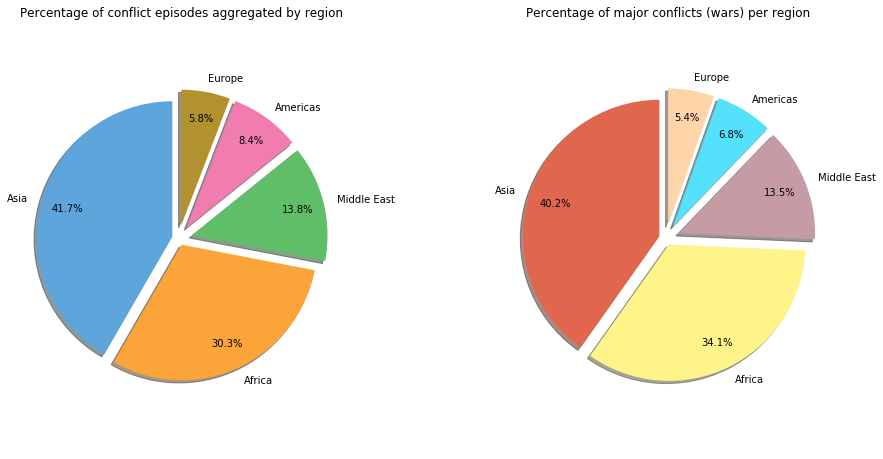

In [252]:
# Pie plot representing the regional distribution of conflict episodes
explode = (0.05, 0.05, 0.1, 0.1, 0.1)
colours1 = ["#5DA5DA", "#FAA43A", "#60BD68", "#F17CB0", "#B2912F"]
colours2 = ["#E0674D", "#FFF48A", "#C59BA4", "#54E1FC", "#FDD5A8"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))
fig.tight_layout()
plt.subplots_adjust(top=0.7, wspace = 0.5)
draw_pie_plot(regional_aggregation[:5].values, list(regional_aggregation[:5].keys()), explode, colours1, "Percentage of conflict episodes aggregated by region", ax[0])
draw_pie_plot(regional_war_count['count'], regional_war_count['region'], explode, colours2, 'Percentage of major conflicts (wars) per region', ax[1])
plt.show()

The above pie charts help visualise the total percentage of conflict episodes and the percentage of war events by region. The plot on the left takes into account the total number of conflict episodes registered in the period 1946-2016, regardless of their intensity, while the pie plot on the right focuses on the major incidents which resulted in more than 1'000 battle-related casualties.

The conclusion that can be drawn, judging by the numbers, is that the number of major incidents contributes almost equally to the total in every World region. There isn't a single region that perhaps had a relatively large share of conflicts, but all or the great majority of them being minor.

The only (barely) noticeable differences, that differ by more than one percent point, are Africa and the Americas. Africa has a larger share of wars than conflicts in general, while it is the opposite for the Americas region. This becomes more obvious from the stacked bar plot below, which shows that the percentage of wars over the total number of conflicts in Africa is 30%, which is larger than any other region where the ratio converges towards one quarter.

In [295]:
temp_total_count = regional_aggregation.reset_index().rename(columns={'region': 'count', 'index': 'region'}).sort_values(by='count', ascending=False)[:5]
regional_war_percentage = regional_war_count[['region', 'count']].merge(temp_total_count, on='region')
regional_war_percentage['war_percentage'] = regional_war_percentage['count_x'] / regional_war_percentage['count_y']
regional_war_percentage['total'] = 1
regional_war_percentage

region  count_x  count_y  war_percentage  total
0         Asia      244      944        0.258475      1
1       Africa      207      687        0.301310      1
2  Middle East       82      313        0.261981      1
3     Americas       41      190        0.215789      1
4       Europe       33      132        0.250000      1

Text(0.5,0,'Region')

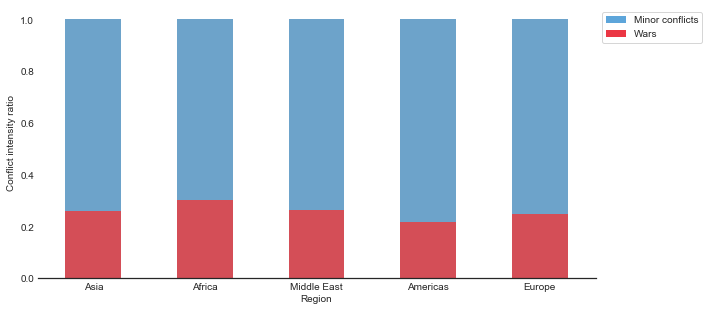

In [445]:
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (10, 5)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = regional_war_percentage['region'], y = regional_war_percentage['total'], color = "#5DA5DA")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = regional_war_percentage['region'], y = regional_war_percentage['war_percentage'], color = "#EB3744")

# Reduce the width of the bars
for patch in bottom_plot.patches:
    current_width = patch.get_width()
    diff = current_width - 0.5

    # we change the bar width
    patch.set_width(0.5)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)


# Create legend
topbar = plt.Rectangle((0,0), 1, 1, fc="#EB3744", edgecolor = 'none')
bottombar = plt.Rectangle((0,0), 1, 1, fc='#5DA5DA',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Minor conflicts', 'Wars'], loc=1, ncol = 1, bbox_to_anchor=(1.2, 1))
l.draw_frame(True)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Conflict intensity ratio")
bottom_plot.set_xlabel("Region")

The plot shows the percentage of armed conflict events that resulted in more than 1'000 deaths opposed to the minor conflicts, aggregated by region. Only the single region events are shown, since the cases of multiregional events are insignificantly small and will only decrease the clarity of the visualisation.

The figure below shows the regional absolute count per intensity level.

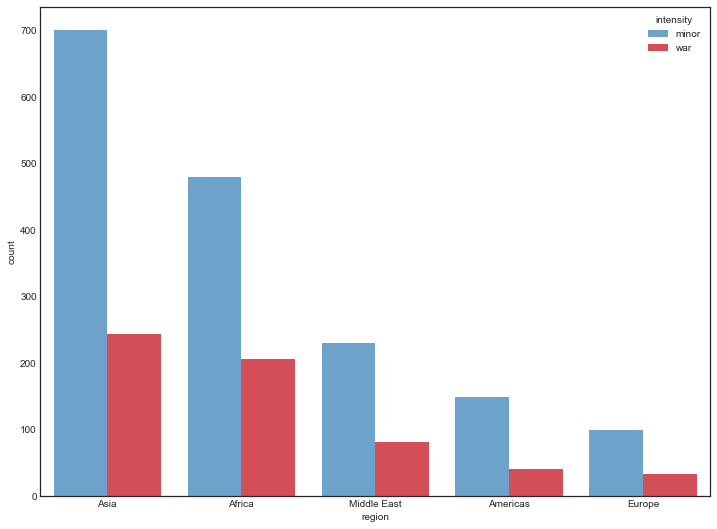

In [346]:
values = region_intensity_aggregated.sort_values(by='count', ascending=False)[:10]

fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x="region", y='count', hue="intensity", data=values, palette=["#5DA5DA", "#EB3744"])
plt.show()

The above bar plot shows the counts of conflict episodes split according to their severity, based on the UCDP definitions taking into account the number of battle-related deaths, i.e. minor conflicts or wars. Minor conflicts are conflict episodes where the number of deaths is between 25 and 999 (inclusive), whereas for an event to be considered a war the number of casualties must rise above 1'000.

### Conflict episode analysis on a location aggregation basis

In [387]:
# Count the number of conflict events grouped by location and intensity
location_aggregated = armed_conflicts_raw.groupby(by=['location', 'intensity']).size()
location_aggregated = location_aggregated.reset_index()
location_aggregated = location_aggregated.rename(columns={0: 'count'})
location_aggregated.head(10)

location intensity  count
0                                        Afghanistan     minor      4
1                                        Afghanistan       war     37
2                 Afghanistan, Russia (Soviet Union)     minor      1
3  Afghanistan, United Kingdom, United States of ...       war      1
4                            Albania, United Kingdom     minor      1
5                                            Algeria     minor     23
6                                            Algeria       war     13
7                                   Algeria, Morocco     minor      1
8                                             Angola     minor     24
9                                             Angola       war     25

There is one subtle issue that needs to be attended to. Namely, there are certain events that have taken place in multiple locations, as is the case with some of the rows visible above: `Afghanistan, Russia (Soviet Union)`; `Albania, United Kingdom`; `Algeria, Morocco`; etc. In order to get a precise count of armed conflict events that happened on the territory of each country, we split the location values to individual countries (separated by a comma) and then add the conflict count to the value of each participant country.

In [389]:
# Split the values of the location column on comma
# Set the columns to keep as indices
temp = pd.DataFrame(location_aggregated['location'].str.split(', ').tolist(), index=[location_aggregated['intensity'], location_aggregated['count']]).stack()
temp = temp.reset_index()[[0, 'intensity', 'count']].rename(columns={0: 'location'})
# Aggregate on the same criterion as before
location_aggregated = temp.groupby(by=['location', 'intensity']).sum().reset_index()
location_aggregated.head()

location intensity  count
0  Afghanistan     minor      5
1  Afghanistan       war     38
2      Albania     minor      1
3      Algeria     minor     24
4      Algeria       war     13

In [407]:
country_conflict_count = location_aggregated.groupby(by='location').sum()
country_conflict_top = country_conflict_count.sort_values(by='count', ascending=False).head(20)
country_conflict_top

count
location                    
Myanmar (Burma)          271
India                    194
Ethiopia                 127
Philippines              100
Israel                    84
Iraq                      73
Colombia                  53
Pakistan                  52
Indonesia                 51
Iran                      50
Angola                    49
Sudan                     48
Cambodia (Kampuchea)      44
Russia (Soviet Union)     43
Afghanistan               43
Uganda                    40
Chad                      40
Turkey                    39
Algeria                   37
Guatemala                 34

The output represents a list of the top 20 countries on whose territory there were armed conflict episodes during the period 1946-2016, which surpassed the annual minimum of 25 battle-related deaths, regardless of whether it was a minor incident or war. Myanmar (Burma) is without doubt the most prominent country in terms of the number of incidents, but approximately 82% of the conflict episodes resulted in less than 1'000 deaths, therefore they are considered minor conflicts. More on the ratio of minor conflicts vs. wars is presented in the following part.

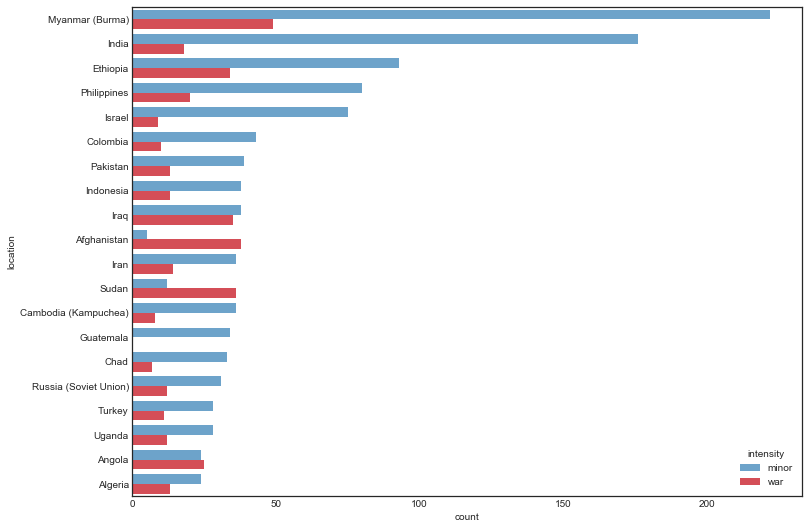

In [417]:
values = location_aggregated[location_aggregated['location'].isin(country_conflict_top.index)]

fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x="count", y='location', hue="intensity", orient='h', data=values.sort_values(by='count', ascending=False), palette=["#5DA5DA", "#EB3744"])
plt.show()

The figure shows the top 20 locations in the World with the largest number of conflict episode events. The total number is then broken down into two components based on the episode intensity level, namely into minor conflicts and wars. It can be easily seen that Myanmar (Burma) is in the lead, both in the number of minor conflicts and wars on its territory, even though the number of wars is significantly smaller compared to the number of minor conflicts.

It is also worth mentioning that Afghanistan, Sudan and Angola have a higher number of wars than minor incidents in their conflict history, with a percentage as high as 88% for Afghanistan and 75% for Sudan out of the total.

The proportion of war episodes in the total number of conflict events for the top locations is more explicitly presented in the following stacked bar plot figure.

In [453]:
location_war_count = location_aggregated[location_aggregated['intensity'] == 'war']
location_war_count = location_war_count[location_war_count['location'].isin(country_conflict_top.index)][['location', 'count']]

location_war_percentage = location_war_count.merge(country_conflict_top.reset_index(), on='location')
location_war_percentage['war_percentage'] = location_war_percentage['count_x'] / location_war_percentage['count_y']
location_war_percentage['total'] = 1

Text(0,0.5,'Location')

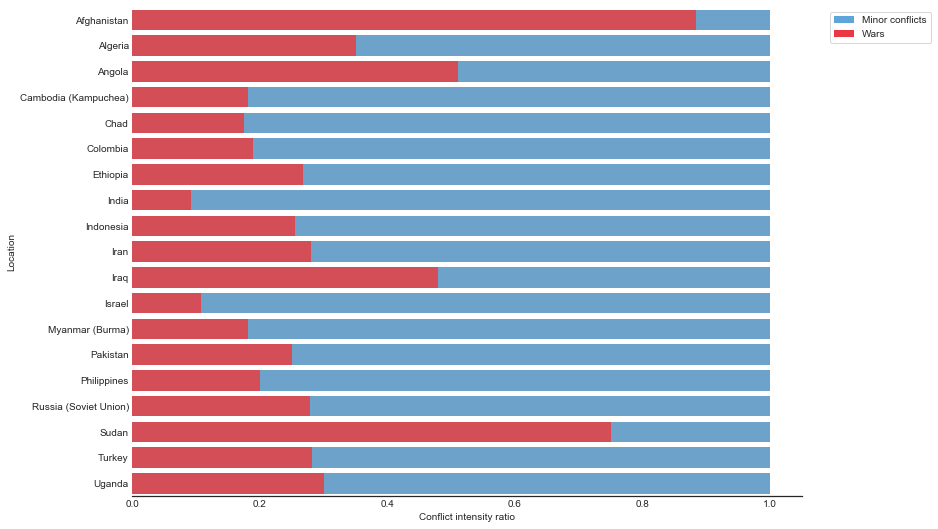

In [451]:
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (12, 9)})

#Plot 1 - background - "total" (top) series
sns.barplot(y = location_war_percentage['location'], x = location_war_percentage['total'], orient='h', color = "#5DA5DA")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(y = location_war_percentage['location'], x = location_war_percentage['war_percentage'], orient='h', color = "#EB3744")

# Create legend
topbar = plt.Rectangle((0,0), 1, 1, fc="#EB3744", edgecolor = 'none')
bottombar = plt.Rectangle((0,0), 1, 1, fc='#5DA5DA',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Minor conflicts', 'Wars'], loc=1, ncol=1, bbox_to_anchor=(1.2, 1))
l.draw_frame(True)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Conflict intensity ratio")
bottom_plot.set_ylabel("Location")

In [2]:
#Due to the size of the output run the notebook with increased iopub limit

#jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000


state_geo = r'world.geo.json'
geo_json_data = json.load(open(state_geo))

confl_map = folium.Map(location=[54.5260, 15.2551], zoom_start=3)
folium.GeoJson(geo_json_data,
               name='geojson'
              ).add_to(confl_map)
confl_map

### Next Steps in our Analysis

1. Choropleth maps with interactive features
2. Integration of all data, plots statistics in one interactive platform(website-blog) (JS-HTML)
3. We are considering in order to win in interactivity to build our maps in Leaflet framework but this will require a tweaking on the code. The leaflet gives us more interactivity but costs us in data manipulation as it is JS and not python. This why we didn't proceed to final version of the maps as still we want to weight the pros and cons of this visualization choice